# PHAS0030 Assignment Week 7

Ben Elliot - 21005900

In this notebook we will be performing a molecular dynamics simulation of the Lennard-Jones model for Neon.

In [1]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Set up the force and energy function

The Lennard Jones potential is givene by:

$$ V(r) = 4 \epsilon [(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6] $$

The force function for the Lennard-Jones potential is given by:

$$ \textbf{F}_i(\textbf{r}_{ij}) = 24 \; \epsilon\;  \textbf{r}_{ij} [\frac{\sigma^6}{r_{ij}^8} - 2 \frac{\sigma^{12}}{r_{ij}^{14}}] $$

In [2]:
def find_forces_LJ(pos,N,sigma,epsilon,boxlen):
    """Calculates the forces and energies of the Lennard-jones potential
    Inputs:
    pos: Positions (Npart x 3 array)
    Npart: Number of particles
    sigma, epsilon  LJ parameters
    boxlen: Length of simulation cell
    
    Returns:
    energy: LJ energy
    force: Forces on particles (Npart x 3 array)
    """
    force = np.zeros((Npart,3))
    energy = 0.0
    sigma6 = sigma**6
    sigma12 = sigma6*sigma6
    for i in range(Npart-1):
        for j in range(i+1,Npart):
            dr = pos[j]-pos[i]
            # Ensure that we interact with the closest particle through periodic boundaries
            # For larger arrays, using np.mod(dr,boxlen) is likely to be more efficient
            dr -= boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)
            dr2i = 1.0/dr2
            dr6i = dr2i*dr2i*dr2i
            fij= 24.0*epsilon*dr*dr2i*dr6i*(sigma6 - 2.0*sigma12*dr6i)
            force[i] += fij
            force[j] -= fij
            energy += 4.0*epsilon*dr6i*(sigma12*dr6i - sigma6)
    return energy, force

### 2. Set up the lattice and the simulation parameters



In [3]:
# Initialisation
Nsteps = 10000  
kB = 1.38e-23         # J/K
sigma = 0.275e-9      # 0.275nm
epsilon = 36*kB       # 36kT
mass = 20.2*1.673e-27 # kg
Ncells = 4
boxlen = 1.1*2**(1/6)*sigma*Ncells
Npart = Ncells*Ncells*Ncells
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1.0/Ncells)*boxlen*np.array([i,j,k])
            count += 1

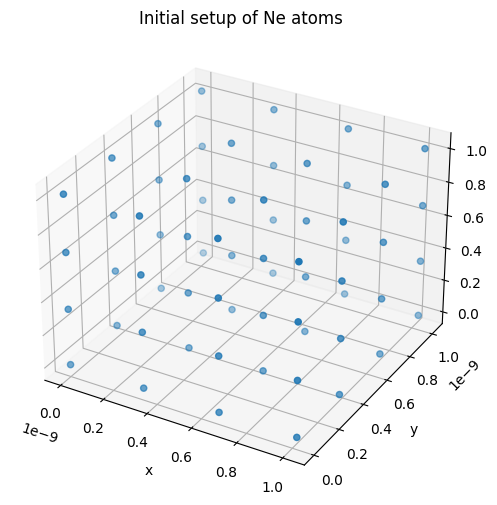

In [4]:
# Plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
ax.set(title="Initial setup of Ne atoms", xlabel='x', ylabel='y', zlabel='z');

### 3. Initialise velocities

In [5]:
# Initialise velocities
initT  = 50          # K
rng = np.random.default_rng()
# The initial distribution can have an arbitrary scaling
vbox3[0] = rng.standard_normal(size=(Npart,3))
# These rescale the velocities
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale

# Initial conditions
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
print("Potential energy and temperature are ",e,"J ",temp[0],"K")
dt = 1e-15 # s -----------------------------------------------------MEANT TO BE 1e-15

MSD = np.zeros((Nsteps))

Potential energy and temperature are  -1.123419416250599e-19 J  50.00000000000001 K


### 4. Run simulation

While running the simulation, we will also be calculating the mean squared displacement (MSD). This is given by the formula:

$$
\frac{1}{N} \Sigma_{i=1}^{N} (\textbf{r}_i(t) - \textbf{r}_i(0))^2
$$

In [6]:
for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc
    # Period boundaries
    rbox3[step] = np.mod(rbox3[step],boxlen)
    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    # Calculate mean-squared displacement
    MSD[step-1] = np.sum((rbox3[step-1] - rbox3[0])**2)
MSD /= Npart


Text(0, 0.5, 'D(t)')

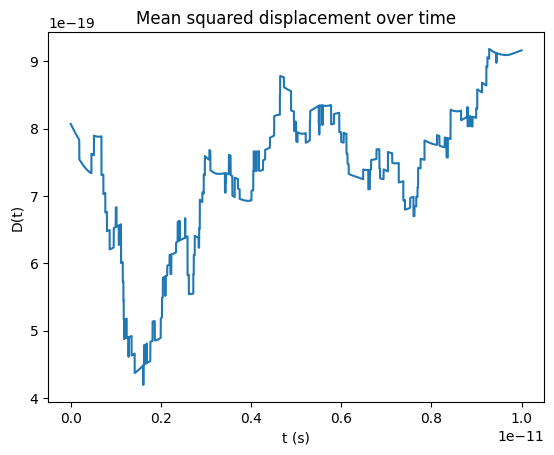

In [7]:
time = dt*np.arange(1,Nsteps-1)
#Graph1 - MSD
plt.figure()
plt.plot(time,MSD[1:-1])
plt.title("Mean squared displacement over time")
plt.xlabel("t (s)")
plt.ylabel("D(t)")


Text(0, 0.5, 'D(t)/6t')

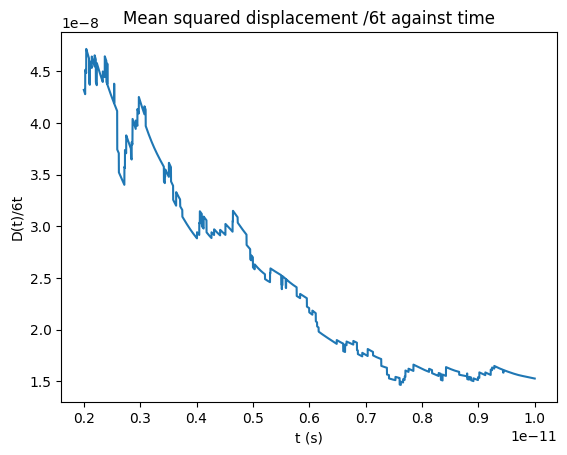

In [8]:
#Graph2 - MSD/6t
plt.figure()
M = 2000
plt.plot(time[M:], MSD[M:-2]/(6*time[M:])) #After first 2 pico seconds
plt.title("Mean squared displacement /6t against time")
plt.xlabel("t (s)")
plt.ylabel("D(t)/6t")

Text(0, 0.5, 'D(t)/6t')

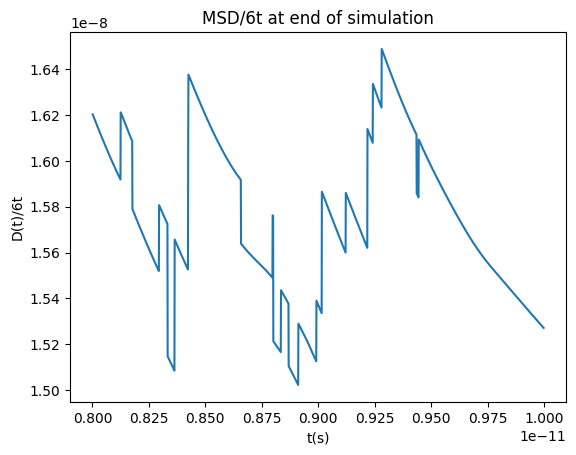

In [9]:
#Plotting just the end points to see where it converges
plt.figure()
M =8000
plt.plot(time[M:], MSD[M:-2]/(6*time[M:])) #After first 2 pico seconds
plt.title("MSD/6t at end of simulation")
plt.xlabel("t(s)")
plt.ylabel("D(t)/6t")

The MSD/6t appears to be converge around 1.56e-8. 

### 5. Calculate the integral

In this next section we will be calculating the auto-correlation function using a rectangle integral, which is given by the formula:

$$
I(t) = \frac{1}{3N} \int_0^t \Sigma_{i=1}^{N} \textbf{v}_i(t) \cdot \textbf{v}_i(0) dt
$$

In [15]:
Int = np.zeros(Nsteps)

for step in range(1,Nsteps):
    Int[step] = Int[step-1] + dt/10 * np.sum(np.dot(vbox3[step].T, vbox3[0]))
Int /= (3*Npart)

Text(0, 0.5, 'I(t)')

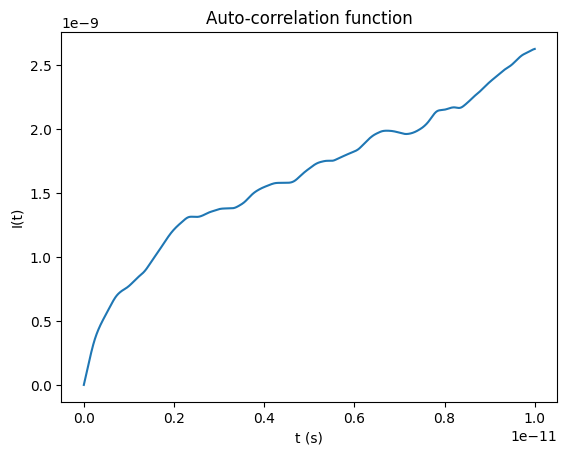

In [16]:
#Graph3 - auto-correlation function
plt.figure()

plt.plot(time, Int[2:]) #After first 2 pico seconds
plt.title("Auto-correlation function")
plt.xlabel("t (s)")
plt.ylabel("I(t)")

## Conclusion
The MSD/6t convereges around 1.56e-8, 1/6 of this is 2.6e-9 which is similar to the value the auto-correlation function, which is heading towards 2.5e-9. The graphs of the MSD/6t and auto-correlation functions do look like they might not have fully converged by the final time step, so a longer run would get us closer to the full converged value.

Running the simulation for longer, however, would be even more computationally expensive, with it taking around 5mins to complete every time on my machine and adding more steps would only make this longer.